# Metrics

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import importlib
import os

#print(os.getcwd())
os.chdir('../')

from src.metrics import ClusteringMetrics
from src.gmm import GaussianMixture

# Scikit-learn for comparison
from sklearn.mixture import GaussianMixture as SklearnGMM
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    fowlkes_mallows_score,
    homogeneity_score,
    mutual_info_score,
    adjusted_mutual_info_score,
    completeness_score,
    v_measure_score,
    rand_score
)

# Detect device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [10]:
np.random.seed(0)  # for reproducibility
n_samples_1 = 1000
n_samples_2 = 800
n_samples_3 = 400
n_samples_4 = 600

center_1 = np.array([0, 0, 0, 0])
center_2 = np.array([-4, 4, -4, 4])
center_3 = np.array([4, -4, 4, -4])
center_4 = np.array([4, 4, 4, 4])

# Random transformation matrices to generate covariances
C_1 = np.random.rand(4, 4)
C_2 = np.random.rand(4, 4)

component_1 = np.dot(np.random.randn(n_samples_1, 4), C_1) + center_1
component_2 = 0.7 * np.random.randn(n_samples_2, 4) + center_2
component_3 = 0.5 * np.random.randn(n_samples_3, 4) + center_3
component_4 = np.dot(np.random.randn(n_samples_4, 4), C_2) + center_4

X = np.concatenate([component_1, component_2, component_3, component_4], axis=0)
y_true = np.concatenate([
    np.zeros(n_samples_1),
    np.ones(n_samples_2),
    np.full(n_samples_3, 2),
    np.full(n_samples_4, 3)
])

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y_true, dtype=torch.long, device=device)

true_n_components = 4
print(f"Data shape: {X_tensor.shape}, true number of clusters: {true_n_components}")


Data shape: torch.Size([2800, 4]), true number of clusters: 4


Evaluating range: 100%|██████████| 9/9 [00:00<00:00, 17.32it/s]


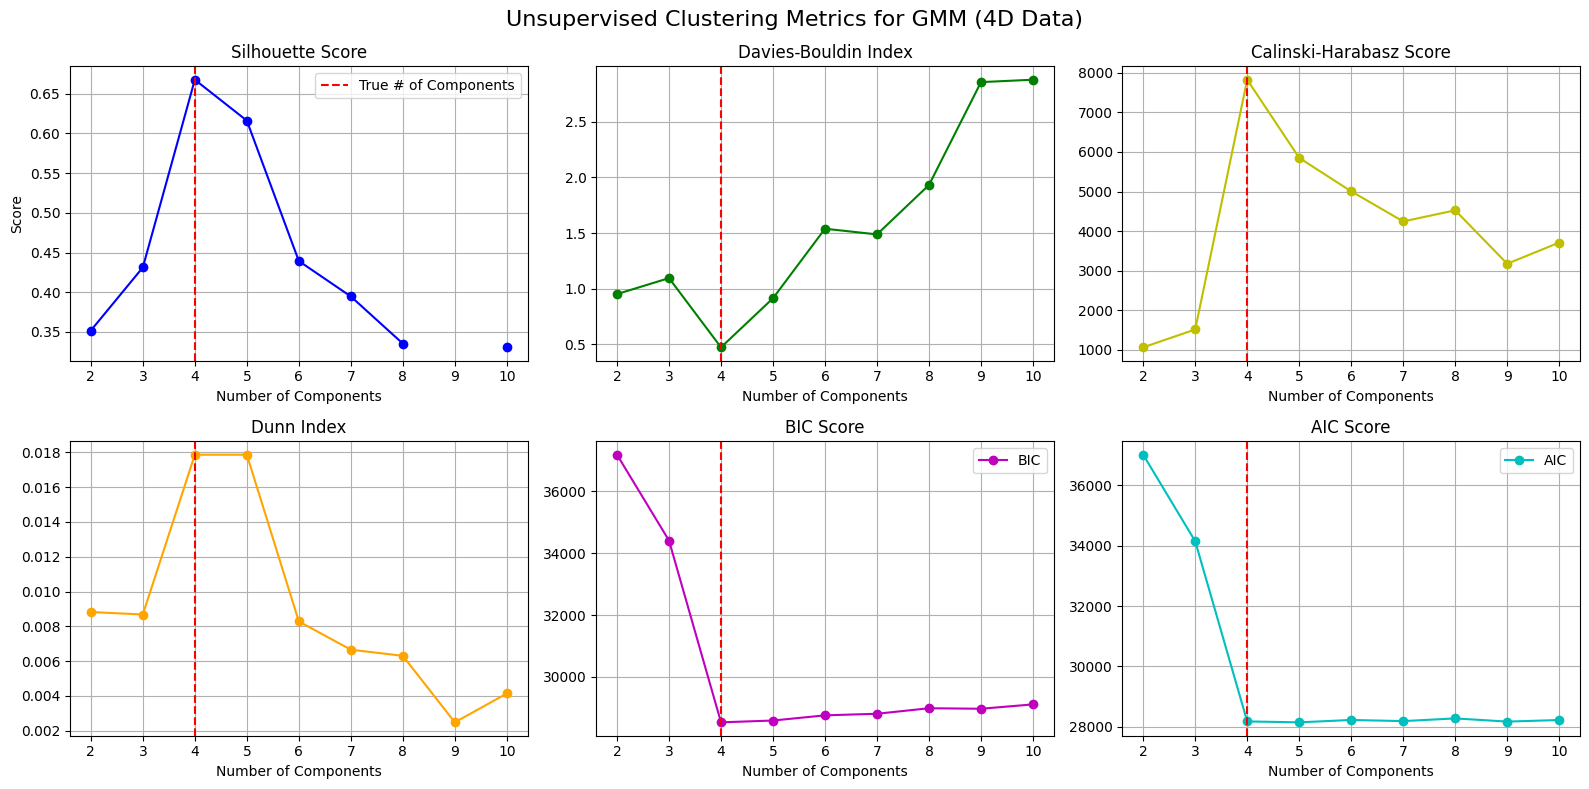

=== Best Number of Components According to Each Metric ===
Silhouette Best: 9
Davies-Bouldin Best (lowest): 4
Calinski-Harabasz Best: 4
Dunn Index Best: 4
BIC Best (lowest): 4
AIC Best (lowest): 5


In [11]:
components_range = np.arange(2, 11)
silhouette_vals = torch.zeros(len(components_range), device=device)
davies_vals = torch.zeros(len(components_range), device=device)
calinski_vals = torch.zeros(len(components_range), device=device)
dunn_vals = torch.zeros(len(components_range), device=device)
bic_vals = torch.zeros(len(components_range), device=device)
aic_vals = torch.zeros(len(components_range), device=device)

# Fit a GMM for each n in components_range
for i, n in tqdm(enumerate(components_range), total=len(components_range), desc="Evaluating range"):
    gmm = GaussianMixture(
        n_features=4,
        n_components=n,
        covariance_type='full',
        max_iter=1000,
        init_params='kmeans',
        device=device
    )
    # Fit
    gmm.fit(X_tensor)
    labels_pred = gmm.predict(X_tensor)  # shape (N,)

    # Compute unsupervised metrics
    silhouette_vals[i] = ClusteringMetrics.silhouette_score(X_tensor, labels_pred, n_components=n)
    davies_vals[i] = ClusteringMetrics.davies_bouldin_index(X_tensor, labels_pred, n_components=n)
    calinski_vals[i] = ClusteringMetrics.calinski_harabasz_score(X_tensor, labels_pred, n_components=n)
    dunn_vals[i] = ClusteringMetrics.dunn_index(X_tensor, labels_pred, n_components=n)
    bic_vals[i] = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, n, gmm.covariance_type)
    aic_vals[i] = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, n, gmm.covariance_type)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# 1) Silhouette
axs[0, 0].plot(components_range, silhouette_vals.cpu(), 'o-b')
axs[0, 0].axvline(x=true_n_components, color='r', linestyle='--', label='True # of Components')
axs[0, 0].set_title('Silhouette Score')
axs[0, 0].set_xlabel('Number of Components')
axs[0, 0].set_ylabel('Score')
axs[0, 0].grid(True)
axs[0, 0].legend()

# 2) Davies-Bouldin
axs[0, 1].plot(components_range, davies_vals.cpu(), 'o-g')
axs[0, 1].axvline(x=true_n_components, color='r', linestyle='--')
axs[0, 1].set_title('Davies-Bouldin Index')
axs[0, 1].set_xlabel('Number of Components')
axs[0, 1].grid(True)

# 3) Calinski-Harabasz
axs[0, 2].plot(components_range, calinski_vals.cpu(), 'o-y')
axs[0, 2].axvline(x=true_n_components, color='r', linestyle='--')
axs[0, 2].set_title('Calinski-Harabasz Score')
axs[0, 2].set_xlabel('Number of Components')
axs[0, 2].grid(True)

# 4) Dunn Index
axs[1, 0].plot(components_range, dunn_vals.cpu(), 'o-', color='orange')
axs[1, 0].axvline(x=true_n_components, color='r', linestyle='--')
axs[1, 0].set_title('Dunn Index')
axs[1, 0].set_xlabel('Number of Components')
axs[1, 0].grid(True)

# 5) BIC
axs[1, 1].plot(components_range, bic_vals.cpu(), 'o-m', label='BIC')
axs[1, 1].axvline(x=true_n_components, color='r', linestyle='--')
axs[1, 1].set_title('BIC Score')
axs[1, 1].set_xlabel('Number of Components')
axs[1, 1].grid(True)
axs[1, 1].legend()

# 6) AIC
axs[1, 2].plot(components_range, aic_vals.cpu(), 'o-c', label='AIC')
axs[1, 2].axvline(x=true_n_components, color='r', linestyle='--')
axs[1, 2].set_title('AIC Score')
axs[1, 2].set_xlabel('Number of Components')
axs[1, 2].grid(True)
axs[1, 2].legend()

plt.suptitle("Unsupervised Clustering Metrics for GMM (4D Data)", fontsize=16)
plt.tight_layout()
plt.show()

print("=== Best Number of Components According to Each Metric ===")
print(f"Silhouette Best: {components_range[torch.argmax(silhouette_vals)].item()}")
print(f"Davies-Bouldin Best (lowest): {components_range[torch.argmin(davies_vals)].item()}")
print(f"Calinski-Harabasz Best: {components_range[torch.argmax(calinski_vals)].item()}")
print(f"Dunn Index Best: {components_range[torch.argmax(dunn_vals)].item()}")
print(f"BIC Best (lowest): {components_range[torch.argmin(bic_vals)].item()}")
print(f"AIC Best (lowest): {components_range[torch.argmin(aic_vals)].item()}")


In [12]:
n_components = true_n_components  # 4
gmm = GaussianMixture(
    n_features=4,
    n_components=n_components,
    covariance_type='full',
    max_iter=1000,
    init_params='kmeans',
    device=device
)
gmm.fit(X_tensor)
labels_pred = gmm.predict(X_tensor)

# Metrics with custom ClusteringMetrics
requested_metrics = [
    "rand_score",
    "adjusted_rand_score",
    "mutual_info_score",
    "normalized_mutual_info_score",
    "adjusted_mutual_info_score",
    "fowlkes_mallows_score",
    "homogeneity_score",
    "completeness_score",
    "v_measure_score",
    "purity_score",
    "silhouette_score",
    "davies_bouldin_index",
    "calinski_harabasz_score",
    "dunn_index",
    "bic_score",
    "aic_score",
]
scores_torch = ClusteringMetrics.evaluate_clustering(
    gmm,
    X_tensor,
    true_labels=y_tensor,
    metrics=requested_metrics
)
print("=== Torch Metrics for n_components=4 ===")
for k, v in scores_torch.items():
    # Some items (e.g. classification_report) could be nested or dict, so check type
    if isinstance(v, (int, float)):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Compare with sklearn
X_np = X_tensor.cpu().numpy()
y_np = y_tensor.cpu().numpy()
labels_pred_np = labels_pred.cpu().numpy()

sk_gmm = SklearnGMM(n_components=n_components, covariance_type='full', max_iter=1000, init_params='kmeans')
sk_gmm.fit(X_np)

scores_sklearn = {
    "rand_score": rand_score(y_np, labels_pred_np),
    "adjusted_rand_score": adjusted_rand_score(y_np, labels_pred_np),
    "mutual_info_score": mutual_info_score(y_np, labels_pred_np),
    "normalized_mutual_info_score": normalized_mutual_info_score(y_np, labels_pred_np),
    "adjusted_mutual_info_score": adjusted_mutual_info_score(y_np, labels_pred_np),
    "fowlkes_mallows_score": fowlkes_mallows_score(y_np, labels_pred_np),
    "homogeneity_score": homogeneity_score(y_np, labels_pred_np),
    "completeness_score": completeness_score(y_np, labels_pred_np),
    "v_measure_score": v_measure_score(y_np, labels_pred_np),
    "silhouette_score": silhouette_score(X_np, labels_pred_np),
    "davies_bouldin_index": davies_bouldin_score(X_np, labels_pred_np),
    "calinski_harabasz_score": calinski_harabasz_score(X_np, labels_pred_np),
}
sk_bic = sk_gmm.bic(X_np)
sk_aic = sk_gmm.aic(X_np)

print("\n=== Sklearn Metrics for n_components=4 ===")
for metric, val in scores_sklearn.items():
    print(f"{metric}: {val:.4f}")
print(f"BIC: {sk_bic:.4f}")
print(f"AIC: {sk_aic:.4f}")

# Compare BIC/AIC with Torch
torch_bic = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, n_components, gmm.covariance_type)
torch_aic = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, n_components, gmm.covariance_type)
print(f"\nTorch BIC: {torch_bic:.4f} vs Sklearn BIC: {sk_bic:.4f}")
print(f"Torch AIC: {torch_aic:.4f} vs Sklearn AIC: {sk_aic:.4f}")


=== Torch Metrics for n_components=4 ===
rand_score: 0.9963
adjusted_rand_score: 0.9908
mutual_info_score: 1.3139
adjusted_mutual_info_score: 0.9852
normalized_mutual_info_score: 0.9852
fowlkes_mallows_score: 0.9934
homogeneity_score: 0.9851
completeness_score: 0.9853
v_measure_score: 0.9852
purity_score: 0.9968
silhouette_score: 0.6674
davies_bouldin_index: 0.4736
calinski_harabasz_score: 7822.9487
dunn_index: 0.0179
bic_score: 28528.9258
aic_score: 28178.6209

=== Sklearn Metrics for n_components=4 ===
rand_score: 0.9963
adjusted_rand_score: 0.9908
mutual_info_score: 1.3139
normalized_mutual_info_score: 0.9852
adjusted_mutual_info_score: 0.9852
fowlkes_mallows_score: 0.9934
homogeneity_score: 0.9851
completeness_score: 0.9853
v_measure_score: 0.9852
silhouette_score: 0.6674
davies_bouldin_index: 0.4736
calinski_harabasz_score: 7822.9492
BIC: 28528.8182
AIC: 28178.5131

Torch BIC: 28528.9258 vs Sklearn BIC: 28528.8182
Torch AIC: 28178.6209 vs Sklearn AIC: 28178.5131


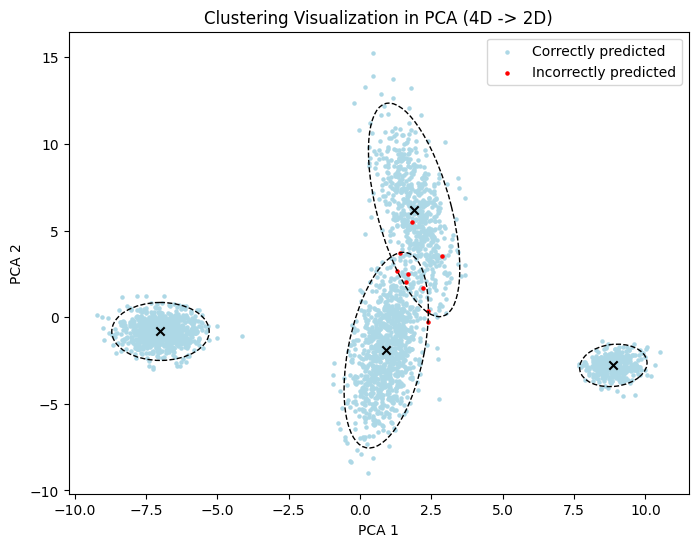

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)  # shape (N, 2)
X_pca_tensor = torch.tensor(X_pca, dtype=torch.float32, device=device)

# Let's define a helper to project means/covariances into PCA space
def transform_means_covariances(means, covariances, pca_sklearn):
    """
    Project the GMM means & covariances into the PCA-reduced space.
    We'll only keep the top 2 principal components, so each covariance
    becomes 2x2 and each mean is 2D.
    """
    means_cpu = means.detach().cpu().numpy()
    means_pca = pca_sklearn.transform(means_cpu)  # NxD -> Nx2

    # For each covariance, do W * Cov * W^T, where W are the top 2 PC loadings.
    W = pca_sklearn.components_[:2, :]  # shape (2, original_dim)
    covariances_pca = []

    if covariances.dim() == 3:  # e.g., 'full' shape = (n_components, d, d)
        for i in range(covariances.size(0)):
            cov_cpu = covariances[i].detach().cpu().numpy()
            cov_2d = W @ cov_cpu @ W.T
            covariances_pca.append(cov_2d)
    else:
        # For diag or spherical, adapt accordingly
        # We'll do an approximate approach for demonstration
        cov_2d = np.diag(covariances[0].cpu().numpy()[:2])
        covariances_pca = [cov_2d for _ in range(means.size(0))]

    covariances_pca = np.stack(covariances_pca, axis=0)
    return torch.tensor(means_pca, dtype=torch.float32), torch.tensor(covariances_pca, dtype=torch.float32)

means_pca, covariances_pca = transform_means_covariances(gmm.means_, gmm.covariances_, pca)

# Next, let's define a quick function to match predicted labels to the
# ground truth using the Hungarian algorithm (so that colors match).
from scipy.optimize import linear_sum_assignment

def match_labels(y_true_tensor, y_pred_tensor):
    y_true_cpu = y_true_tensor.cpu().long()
    y_pred_cpu = y_pred_tensor.cpu().long()
    max_true = y_true_cpu.max().item() + 1
    max_pred = y_pred_cpu.max().item() + 1

    # Contingency matrix
    cont = np.zeros((max_true, max_pred), dtype=int)
    for i in range(y_true_cpu.size(0)):
        cont[y_true_cpu[i], y_pred_cpu[i]] += 1

    row_ind, col_ind = linear_sum_assignment(-cont)  # maximize
    mapping = {col_ind[j]: row_ind[j] for j in range(len(row_ind))}

    matched_labels = np.array([mapping.get(p, p) for p in y_pred_cpu.numpy()], dtype=int)
    return matched_labels

matched_pred = match_labels(y_tensor, labels_pred)

# Let's visualize
fig, ax = plt.subplots(figsize=(8, 6))

correct = (matched_pred == y_tensor.cpu().numpy())
incorrect = ~correct

ax.scatter(X_pca[correct, 0], X_pca[correct, 1], c='lightblue', s=5, label='Correctly predicted')
ax.scatter(X_pca[incorrect, 0], X_pca[incorrect, 1], c='red', s=5, label='Incorrectly predicted')

# Plot the 2D means + ellipses for each component
n_comps = gmm.means_.shape[0]
for i in range(n_comps):
    mean_2d = means_pca[i].numpy()
    cov_2d = covariances_pca[i].numpy()

    ax.scatter(mean_2d[0], mean_2d[1], c='black', marker='x')
    # Ellipse for ~95% confidence region: factor ~5.991 for 2D
    eigvals, eigvecs = np.linalg.eigh(cov_2d)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigvals)
    ell = Ellipse(mean_2d, width, height, angle=angle, edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(ell)

ax.set_title("Clustering Visualization in PCA (4D -> 2D)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend()
plt.show()



Confusion Matrix:
 tensor([[996,   0,   0,   4],
        [  0, 800,   0,   0],
        [  0,   0, 400,   0],
        [  5,   0,   0, 595]], dtype=torch.int32)

Classification Report:
 {0: {'precision': 0.995004995004995, 'recall': 0.996, 'f1-score': 0.9955022488755622, 'support': 1000, 'jaccard': 0.991044776119403, 'roc_auc': 0.99549400806427}, 1: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 800, 'jaccard': 1.0, 'roc_auc': 1.0}, 2: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400, 'jaccard': 1.0, 'roc_auc': 1.0}, 3: {'precision': 0.993322203672788, 'recall': 0.9916666666666667, 'f1-score': 0.9924937447873228, 'support': 600, 'jaccard': 0.9850993377483444, 'roc_auc': 0.9971325993537903}}


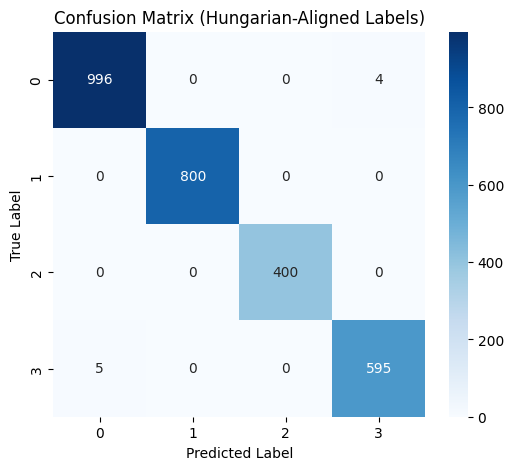

,precision,recall,f1-score,support,jaccard,roc_auc
0,0.995005,0.996000,0.995502,1000.0,0.991045,0.995494
1,1.000000,1.000000,1.000000,800.0,1.000000,1.000000
2,1.000000,1.000000,1.000000,400.0,1.000000,1.000000
3,0.993322,0.991667,0.992494,600.0,0.985099,0.997133


In [14]:
cm = ClusteringMetrics.confusion_matrix(
    torch.tensor(y_true, dtype=torch.long),
    torch.tensor(matched_pred, dtype=torch.long)
)
print("\nConfusion Matrix:\n", cm)

report = ClusteringMetrics.classification_report(
    torch.tensor(y_true, dtype=torch.long),
    torch.tensor(matched_pred, dtype=torch.long)
)
print("\nClassification Report:\n", report)

# Heatmap of confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Hungarian-Aligned Labels)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Convert classification report to a DataFrame for display
report_df = pd.DataFrame(report).T
report_df


Computing KL(p||q) for different numbers of components...


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


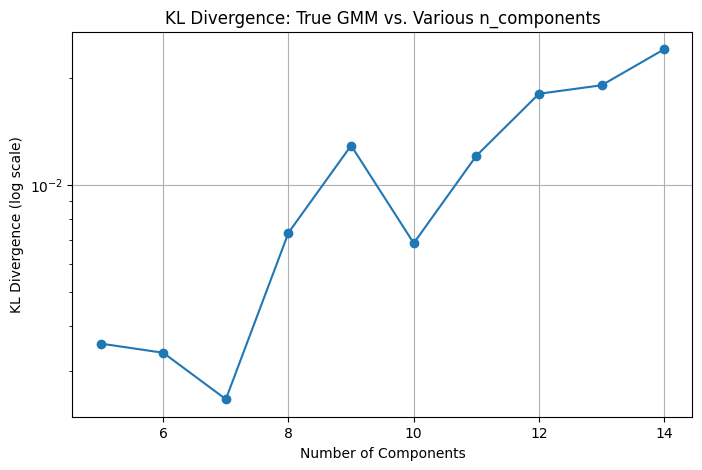

In [15]:
RUN_KL_DIVERGENCE = True
if RUN_KL_DIVERGENCE:
    print("Computing KL(p||q) for different numbers of components...")
    gmm_true = GaussianMixture(
        n_features=4,
        n_components=true_n_components,
        covariance_type='full',
        max_iter=1000,
        init_params='kmeans',
        device=device
    )
    gmm_true.fit(X_tensor)
    
    test_range = np.arange(5, 15)
    kl_vals = torch.zeros(len(test_range), device=device)
    for i, n in tqdm(enumerate(test_range), total=len(test_range)):
        gmm_test = GaussianMixture(
            n_features=4,
            n_components=n,
            covariance_type='full',
            max_iter=1000,
            init_params='kmeans',
            device=device
        )
        gmm_test.fit(X_tensor)
        
        kl_vals[i] = ClusteringMetrics.kl_divergence_gmm(gmm_true, gmm_test, n_samples=10000)

    plt.figure(figsize=(8, 5))
    plt.plot(test_range, kl_vals.cpu().numpy(), marker='o')
    plt.yscale('log')
    plt.title("KL Divergence: True GMM vs. Various n_components")
    plt.xlabel("Number of Components")
    plt.ylabel("KL Divergence (log scale)")
    plt.grid(True)
    plt.show()
